In [5]:
import numpy as np
import pandas as pd
import os
import torch
import tarfile
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt

In [6]:
data_url='https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz'
download_url(data_url,'.')

Using downloaded and verified file: ./cifar10.tgz


In [7]:
with tarfile.open('./cifar10.tgz','r:gz') as tar:
    tar.extractall(path='./data')

In [8]:
data_dir='./data/cifar10'
print(os.listdir(data_dir))
classes=os.listdir(data_dir+'/train')
print(classes)

['test', 'train']
['horse', 'airplane', 'frog', 'truck', 'bird', 'deer', 'dog', 'ship', 'cat', 'automobile']


In [9]:
# we will use the test set for validation and the entire training data for training
# the model

In [10]:
# mean for red channels, mean for green,...
stats=((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010))
train_transf=tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'),
                         tt.RandomHorizontalFlip(),
                         tt.ToTensor(),
                         tt.Normalize(*stats, inplace=True)])
valid_transf=tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [11]:
train_ds=ImageFolder(data_dir+'/train',train_transf)
val_ds=ImageFolder(data_dir+'/test',valid_transf)

In [12]:
batch_size=400

In [13]:
train_dl=DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
val_dl=DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [14]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

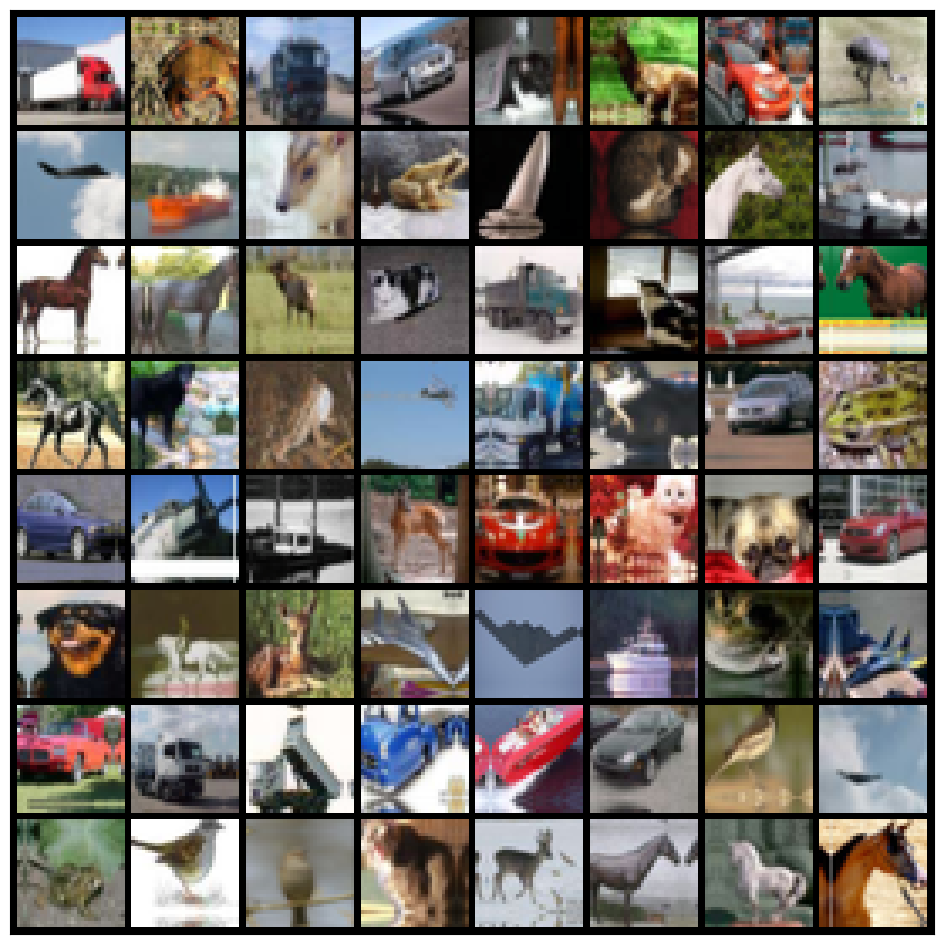

In [15]:
show_batch(train_dl)

In [16]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [17]:
device=get_default_device()
device

device(type='cuda')

In [18]:
train_dl=DeviceDataLoader(train_dl, device)
val_dl=DeviceDataLoader(val_dl, device)

##Model with Residual Blocks and Batch Normalization\

We add a Residual block: it adds the original input back to the output feature map obtained by passing the input through one or more convolutional layers

In [19]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1=nn.ReLU()
        self.conv2=nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2=nn.ReLU()

    def forward(self,x):
      out=self.conv1(x)
      out=self.relu1(out)
      out=self.conv2(out)
      return self.relu2(out)+x

In [20]:
simple_resnet=to_device(SimpleResidualBlock(), device)

for images, labels in train_dl:
    print(images.shape)
    out=simple_resnet(images)
    print(out.shape)
    break
del simple_resnet, images,labels
torch.cuda.empty_cache()

torch.Size([400, 3, 32, 32])
torch.Size([400, 3, 32, 32])


In [21]:
#  Batch normalization layer normalizes the outputs of the previous layer

#  we will use the resnet9 architecture

In [22]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [23]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64) #64x32x32
        self.conv2 = conv_block(64, 128, pool=True) # 128x16x16
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True)    # 256x8x8
        self.conv4 = conv_block(256, 512, pool=True)    # 512x4x4
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
                                                        # 512x4x4

        self.classifier = nn.Sequential(nn.MaxPool2d(4),  #512 x 1 x 1
                                        nn.Flatten(),     #512
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [24]:
model = to_device(ResNet9(3, 10), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [28]:
# weight decay
# one cycle policy for learning rate
# gradient clipping

In [29]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()   #dropout is not applied during this phase
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()  #compute the gradient

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()  #perform gradient descent using the optimization technique
            optimizer.zero_grad()         #set gradient back to 0

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [26]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 2.3041839599609375, 'val_acc': 0.10451923310756683}]

In [47]:
epochs=16
max_lr=0.01
grad_clip=0.1
weight_decay=1e-5
opt_func=torch.optim.Adam

In [48]:
history+=fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                       grad_clip=grad_clip, weight_decay=weight_decay, opt_func=opt_func)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [0], last_lr: 0.00138, train_loss: 0.2570, val_loss: 0.3737, val_acc: 0.8758
Epoch [1], last_lr: 0.00394, train_loss: 0.3550, val_loss: 0.7654, val_acc: 0.7740
Epoch [2], last_lr: 0.00703, train_loss: 0.4438, val_loss: 0.7464, val_acc: 0.7794
Epoch [3], last_lr: 0.00935, train_loss: 0.4400, val_loss: 0.6395, val_acc: 0.7947
Epoch [4], last_lr: 0.00999, train_loss: 0.4104, val_loss: 0.6196, val_acc: 0.8088
Epoch [5], last_lr: 0.00972, train_loss: 0.3681, val_loss: 0.6265, val_acc: 0.8069
Epoch [6], last_lr: 0.00908, train_loss: 0.3233, val_loss: 0.4036, val_acc: 0.8705
Epoch [7], last_lr: 0.00812, train_loss: 0.2828, val_loss: 0.5465, val_acc: 0.8356
Epoch [8], last_lr: 0.00691, train_loss: 0.2552, val_loss: 0.7314, val_acc: 0.8121
Epoch [9], last_lr: 0.00556, train_loss: 0.2197, val_loss: 0.4170, val_acc: 0.8651
Epoch [10], last_lr: 0.00416, train_loss: 0.1756, val_loss: 0.3008, val_acc: 0.9043
Epoch [11], last_lr: 0.00283, train_loss: 0.1378, val_loss: 0.2938, val_acc: 0.9130
Ep

In [49]:
def plot_accuracies(history):
    accuracies=[x['val_acc'] for x in history]
    plt.plot(accuracies,'-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('accuracy vs no of epochs')

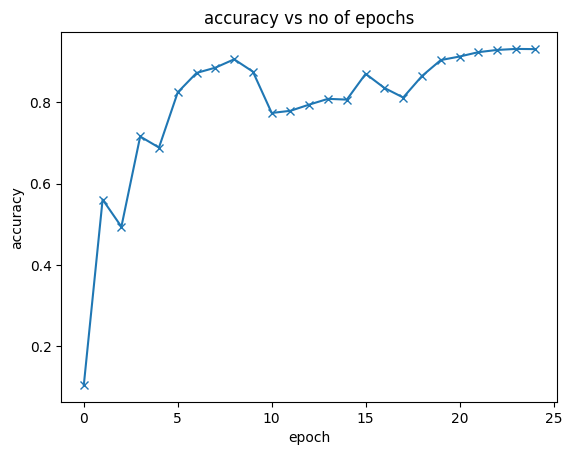

In [50]:
plot_accuracies(history)

In [34]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

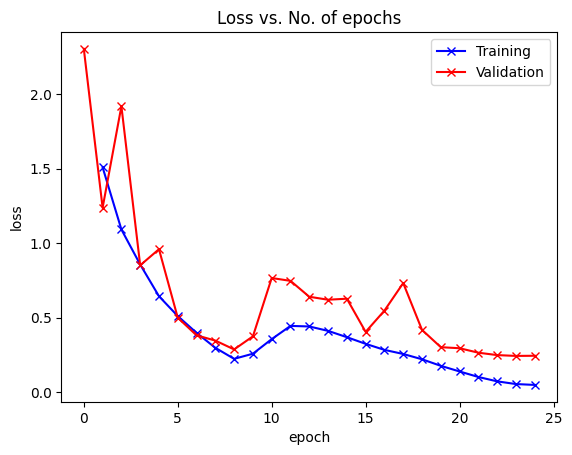

In [51]:
plot_losses(history)

In [36]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

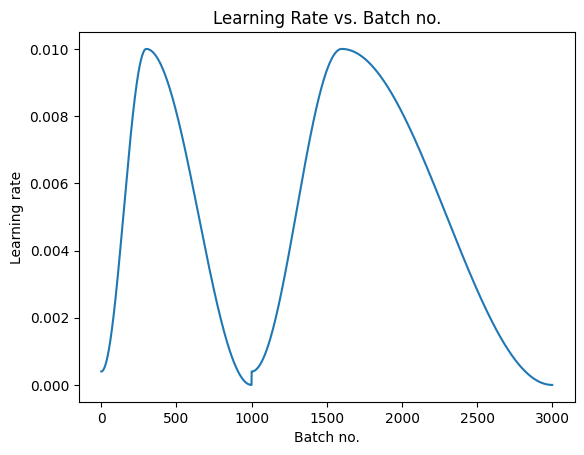

In [52]:
plot_lrs(history)

In [38]:
# Testing with individual images

In [41]:
def predict_image(img, model):
    # convert to a batch of 1
    xb=to_device(img.unsqueeze(0), device)
    # get predictions from model
    yb=model(xb)
    # pick index with highest probability
    _, preds=torch.max(yb, dim=1)
    # retrieve the class label
    return train_ds.classes[preds[0].item()]

label:  airplane , predicted:  airplane


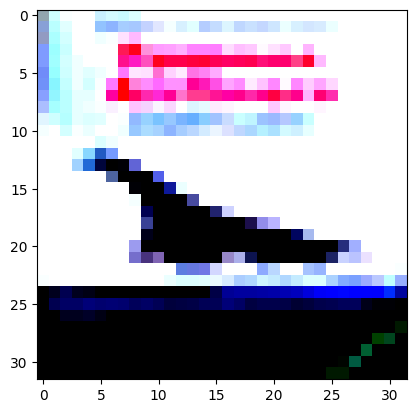

In [42]:
img, label=val_ds[0]
plt.imshow(img.permute(1,2,0).clamp(0,1))
print('label: ', train_ds.classes[label], ', predicted: ',predict_image(img, model))

label:  truck , predicted:  truck


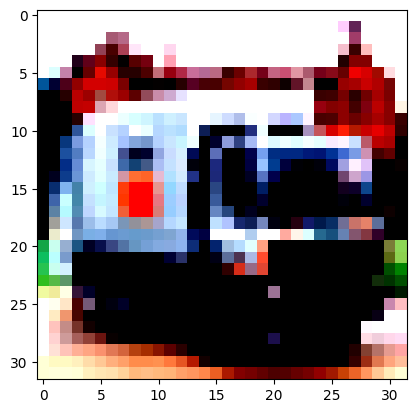

In [55]:
img, label=val_ds[9000]
plt.imshow(img.permute(1,2,0).clamp(0,1))
print('label: ', train_ds.classes[label], ', predicted: ',predict_image(img, model))

label:  frog , predicted:  frog


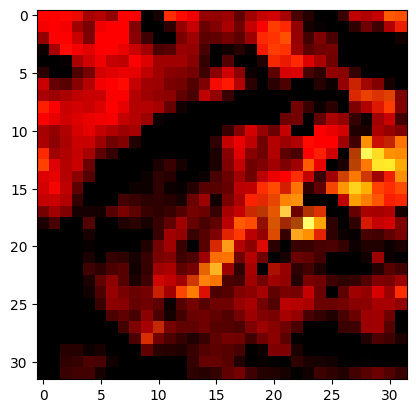

In [53]:
img, label=val_ds[6200]
plt.imshow(img.permute(1,2,0).clamp(0,1))
print('label: ', train_ds.classes[label], ', predicted: ',predict_image(img, model))

label:  deer , predicted:  deer


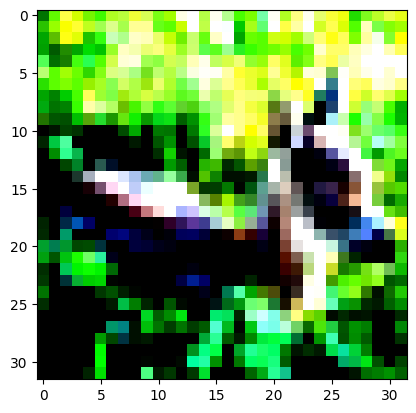

In [57]:
img, label=val_ds[4169]
plt.imshow(img.permute(1,2,0).clamp(0,1))
print('label: ', train_ds.classes[label], ', predicted: ',predict_image(img, model))

In [58]:
torch.save(model.state_dict(), 'cifar10-resnet9.pth')